In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Collection
Steps:

Convert PSD files to JSON.
Ensure each JSON contains comprehensive layout details.
Code (Python script to convert PSD to JSON):

In [ ]:
!pip install pandas

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def load_json_files(root_directory):
    json_data = []
    for dirpath, dirnames, files in os.walk(root_directory):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(dirpath, file_name)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    json_data.append(data)
    return json_data

def preprocess_data(json_data):
    features = []
    for item in json_data:
        if 'folders' in item:
            for folder in item['folders']:
                try:
                    features.append([
                        folder['bbox'][0],  # x coordinate
                        folder['bbox'][1],  # y coordinate
                        folder['width'],
                        folder['height'],
                        folder['name']  # Assuming 'name' could serve as a type indicator
                    ])
                except KeyError as e:
                    print(f"Key error: {e} in folder {folder}")
        if 'layers' in item:
            for layer_name, layers in item['layers'].items():
                for layer in layers:
                    try:
                        features.append([
                            layer['bbox'][0],
                            layer['bbox'][1],
                            layer['width'],
                            layer['height'],
                            layer['type']
                        ])
                    except KeyError as e:
                        print(f"Key error: {e} in layer {layer}")
    return features

# Load and preprocess the data
root_directory = '/content/drive/MyDrive/psd'
json_data = load_json_files(root_directory)
processed_features = preprocess_data(json_data)

# Convert list to numpy array for further processing
features = np.array(processed_features, dtype=object)

# Handle numerical data normalization
scaler = MinMaxScaler()
numerical_data = scaler.fit_transform(features[:, :4].astype(float))

# Handle categorical data encoding
encoder = LabelEncoder()
categorical_data = encoder.fit_transform(features[:, 4])

# Combine processed data
processed_data = np.hstack((numerical_data, categorical_data.reshape(-1, 1)))

# Define input shape
input_shape = (processed_data.shape[1] - 1,)  # Exclude the categorical column from input shape

# Split data into training and validation sets
split_index = int(0.8 * len(processed_data))
train_features = processed_data[:split_index, :-1]  # Exclude the categorical column
train_labels = processed_data[:split_index, :4]  # Use only the numerical columns for labels
val_features = processed_data[split_index:, :-1]  # Exclude the categorical column
val_labels = processed_data[split_index:, :4]  # Use only the numerical columns for labels


Epoch 1/50
799/799 [==============================] - 3s 3ms/step - loss: 6.2661e-04 - mae: 0.0062 - accuracy_metric: 0.9897 - val_loss: 1.6868e-06 - val_mae: 0.0010 - val_accuracy_metric: 1.0000
Epoch 2/50
799/799 [==============================] - 2s 3ms/step - loss: 9.3779e-06 - mae: 0.0016 - accuracy_metric: 1.0000 - val_loss: 1.4852e-06 - val_mae: 6.8969e-04 - val_accuracy_metric: 1.0000
Epoch 3/50
799/799 [==============================] - 3s 4ms/step - loss: 4.0084e-06 - mae: 0.0013 - accuracy_metric: 1.0000 - val_loss: 1.4072e-06 - val_mae: 8.2121e-04 - val_accuracy_metric: 1.0000
Epoch 4/50
799/799 [==============================] - 3s 4ms/step - loss: 4.0223e-06 - mae: 0.0013 - accuracy_metric: 1.0000 - val_loss: 1.9131e-06 - val_mae: 9.4758e-04 - val_accuracy_metric: 1.0000
Epoch 5/50
799/799 [==============================] - 2s 3ms/step - loss: 7.5538e-06 - mae: 0.0018 - accuracy_metric: 1.0000 - val_loss: 2.2246e-06 - val_mae: 0.0011 - val_accuracy_metric: 1.0000
Epoch 6/

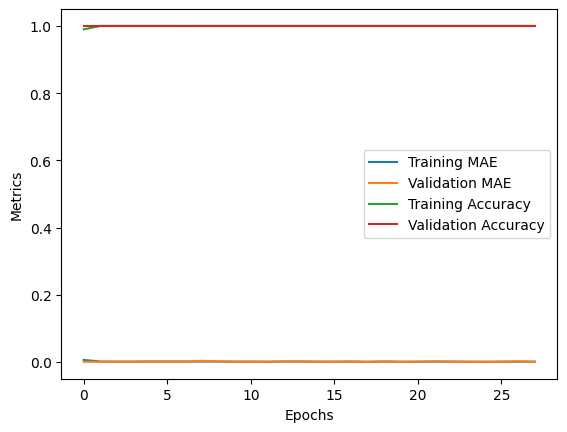

In [11]:
def build_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(4)  # The output should be of size 4: x, y, width, height
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', accuracy_metric])
    return model

# Custom accuracy metric for regression
def custom_accuracy(y_true, y_pred, threshold=0.1):
    diff = tf.abs(y_true - y_pred)
    correct = tf.less_equal(diff, threshold)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

def accuracy_metric(y_true, y_pred):
    return custom_accuracy(y_true, y_pred)

# Build and compile model
model = build_model(input_shape)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_features, train_labels, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Save the model
model.save('model.keras')

# Evaluate model performance
train_loss, train_mae, train_acc = model.evaluate(train_features, train_labels)
print(f'Training Mean Absolute Error: {train_mae}')
print(f'Training Accuracy: {train_acc * 100:.2f}%')

val_loss, val_mae, val_acc = model.evaluate(val_features, val_labels)
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation Accuracy: {val_acc * 100:.2f}%')


# Plot training history
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.plot(history.history['accuracy_metric'], label='Training Accuracy')
plt.plot(history.history['val_accuracy_metric'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


In [ ]:
import json
import numpy as np
import tensorflow as tf
from google.colab import files

# Custom accuracy metric for regression
def custom_accuracy(y_true, y_pred, threshold=0.1):
    diff = tf.abs(y_true - y_pred)
    correct = tf.less_equal(diff, threshold)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

def accuracy_metric(y_true, y_pred):
    return custom_accuracy(y_true, y_pred)

def extract_features(json_data):
    features = []
    if 'layers' in json_data and isinstance(json_data['layers'], dict):
        for folder_name, layers in json_data['layers'].items():
            for layer in layers:
                try:
                    if ('bbox' in layer and isinstance(layer['bbox'], list) and len(layer['bbox']) == 4 and
                        'width' in layer and 'height' in layer):
                        features.append([
                            layer['bbox'][0],  # x position
                            layer['bbox'][1],  # y position
                            layer['width'],    # width
                            layer['height'],   # height
                        ])
                except Exception as e:
                    print(f"Error processing layer: {layer.get('name', 'Unknown') if isinstance(layer, dict) else 'Unknown'}, error: {e}")
    else:
        print(f"JSON data skipped because 'layers' is missing or not a dictionary: {json_data}")
    return np.array(features)

def generate_new_layout(model, input_json):
    features = extract_features(input_json)
    new_layout = model.predict(features)
    # Convert predicted features back to JSON format
    new_json = {"layers": {}}
    for folder_name, layers in input_json['layers'].items():
        new_json["layers"][folder_name] = []
        for i, layer in enumerate(layers):
            new_layer = {
                "name": layer["name"],
                "bbox": [float(new_layout[i][0]), float(new_layout[i][1])],
                "width": float(new_layout[i][2]),
                "height": float(new_layout[i][3]),
                "type": layer["type"],
                "visible": layer["visible"],
                "opacity": layer["opacity"]
            }
            if "content" in layer:
                new_layer["content"] = layer["content"]
            new_json["layers"][folder_name].append(new_layer)
    return new_json

def scale_layout(input_json, original_size, new_size):
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    scaled_json = {"layers": {}}
    for folder_name, layers in input_json['layers'].items():
        scaled_json["layers"][folder_name] = []
        for layer in layers:
            scaled_layer = {
                "name": layer["name"],
                "bbox": [layer["bbox"][0] * scale_x, layer["bbox"][1] * scale_y],
                "width": layer["width"] * scale_x,
                "height": layer["height"] * scale_y,
                "type": layer["type"],
                "visible": layer["visible"],
                "opacity": layer["opacity"]
            }
            if "content" in layer:
                scaled_layer["content"] = layer["content"]
            scaled_json["layers"][folder_name].append(scaled_layer)
    return scaled_json

# List of new sizes
sizes = [
    (300, 250), (728, 90), (336, 280), (300, 600), (320, 50),
    (160, 600), (970, 250), (1200, 628), (1080, 1080), (1200, 675),
    (1200, 630), (400, 400), (1500, 500)
]

# Assuming the original size is 1200x628
original_size = (1200, 628)

# Upload JSON file
uploaded = files.upload()

# Assuming only one file is uploaded
input_file = list(uploaded.keys())[0]

# Load the trained model
model_path = 'model.keras'
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path, custom_objects={'accuracy_metric': accuracy_metric})

    # Process the uploaded file
    with open(input_file, 'r') as json_file:
        input_json = json.load(json_file)

        # Generate new layout for the original size
        new_layout_json = generate_new_layout(model, input_json)

        # Generate new layouts for different sizes
        for size in sizes:
            scaled_layout_json = scale_layout(new_layout_json, original_size, size)
            output_file = f'output_{size[0]}x{size[1]}_' + input_file
            with open(output_file, 'w') as f:
                json.dump(scaled_layout_json, f)

            # Download the output file
            files.download(output_file)
else:
    print(f"Model path '{model_path}' does not exist.")
